## 습도 범주 별 마스크 판매량

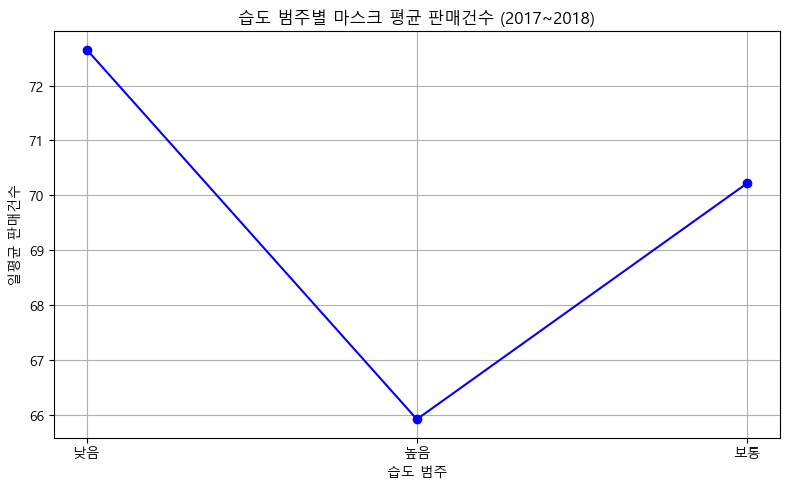

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 습도 데이터 로딩 및 전처리
air_2017 = pd.read_csv("./data/SURFACE_air_pollution_2017.csv", encoding="cp949")
air_2018 = pd.read_csv("./data/SURFACE_air_pollution_2018.csv", encoding="cp949")
humidity_df = pd.concat([air_2017, air_2018], ignore_index=True)

humidity_df = humidity_df[["일시", "습도(%)"]].dropna()
humidity_df.columns = ["일시", "습도"]
humidity_df["일시"] = pd.to_datetime(humidity_df["일시"], errors="coerce")
humidity_df = humidity_df.dropna(subset=["일시"])
humidity_daily = humidity_df.groupby(humidity_df["일시"].dt.date)["습도"].mean().reset_index()
humidity_daily.columns = ["날짜", "평균습도"]
humidity_daily["날짜"] = pd.to_datetime(humidity_daily["날짜"])

# 2. 마스크 판매 데이터 로딩 및 날짜 처리
mask_df = pd.read_csv("./data/20190509_mask_POS.csv", encoding="utf-8")
mask_df["Calendar Day일 2"] = pd.to_datetime(mask_df["Calendar Day일 2"], errors="coerce")
mask_df = mask_df.dropna(subset=["Calendar Day일 2"])
mask_df = mask_df[mask_df["Calendar Day일 2"].dt.year <= 2018]  # 2018년까지 필터링

# 3. 일자별 판매건수 집계
mask_daily = mask_df.groupby(mask_df["Calendar Day일 2"].dt.date).size().reset_index(name="판매건수")
mask_daily.columns = ["날짜", "판매건수"]
mask_daily["날짜"] = pd.to_datetime(mask_daily["날짜"])

# 4. 판매 데이터와 습도 병합
merged_df = pd.merge(mask_daily, humidity_daily, on="날짜", how="inner")

# 5. 습도 범주 구분
def humidity_category(h):
    if h < 40:
        return "낮음"
    elif h <= 70:
        return "보통"
    else:
        return "높음"

merged_df["습도범주"] = merged_df["평균습도"].apply(humidity_category)

# 6. 범주별 평균 판매건수 계산
summary = merged_df.groupby("습도범주")["판매건수"].mean().reset_index()

# 7. 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'  # macOS는 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 꺾은선그래프
plt.figure(figsize=(8, 5))
plt.plot(summary['습도범주'], summary['판매건수'], marker='o', linestyle='-', color='blue')

plt.title('습도 범주별 마스크 평균 판매건수 (2017~2018)')
plt.xlabel('습도 범주')
plt.ylabel('일평균 판매건수')
plt.grid(True)
plt.tight_layout()
plt.show()

## 미세먼지(PM10) 등급 별 대기오염 물질의 평균 농도

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


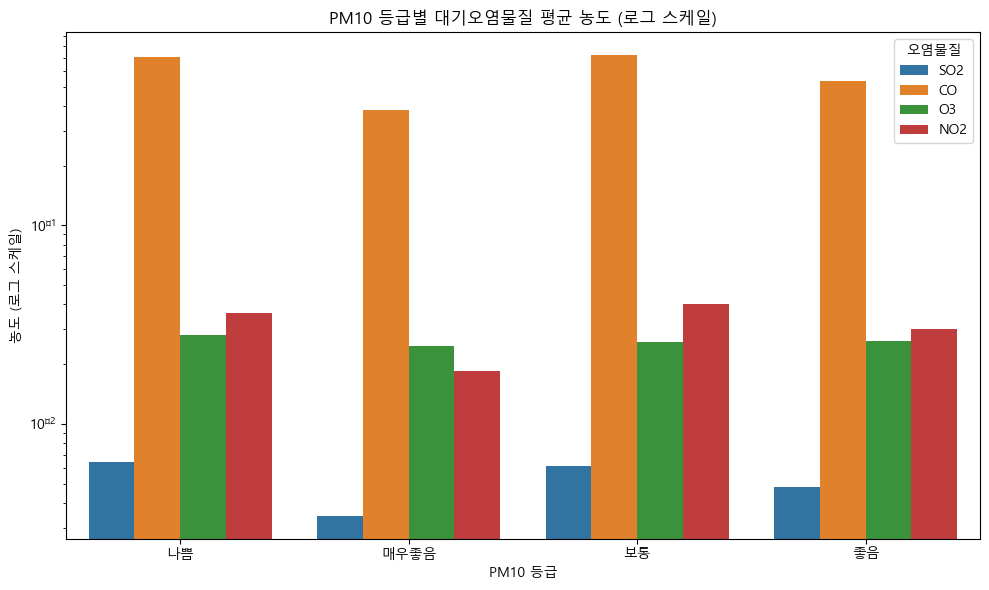

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 사용할 파일 목록
dust_files = [
    './data/1701Q_dust.csv',
    './data/1702Q_dust.csv',
    './data/1703Q_dust.csv',
    './data/1704Q_dust.csv',
    './data/1801Q_dust.csv',
    './data/1802Q_dust.csv',
    './data/1803Q_dust.csv',
]

# 2. 필요한 열만 선택해서 메모리 절약하며 불러오기
required_columns = ['SO2', 'CO', 'O3', 'NO2', 'PM10']
dust_df_list = [
    pd.read_csv(file, encoding='utf-8', usecols=lambda c: c in required_columns)
    for file in dust_files
]
dust_df = pd.concat(dust_df_list, ignore_index=True)

# 3. 결측치 제거 및 PM10 등급 분류
dust_df = dust_df.dropna(subset=['PM10'])

def pm10_grade(pm10):
    if pm10 <= 30:
        return '매우좋음'
    elif pm10 <= 80:
        return '좋음'
    elif pm10 <= 150:
        return '보통'
    else:
        return '나쁨'

dust_df['PM10등급'] = dust_df['PM10'].apply(pm10_grade)

# 4. 등급별 오염물질 평균값 계산
pollutant_cols = ['SO2', 'CO', 'O3', 'NO2']
grouped = dust_df.groupby('PM10등급')[pollutant_cols].mean().reset_index()

# 5. 시각화를 위한 long format 변환
dust_pollutants_melted = grouped.melt(id_vars='PM10등급', var_name='오염물질', value_name='농도')

# 6. 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 사용자용
plt.rcParams['axes.unicode_minus'] = False     # 음수 깨짐 방지

plt.figure(figsize=(10, 6))
sns.barplot(data=dust_pollutants_melted, x='PM10등급', y='농도', hue='오염물질')
plt.yscale('log')  # 로그 스케일 적용
plt.title('PM10 등급별 대기오염물질 평균 농도 (로그 스케일)')
plt.xlabel('PM10 등급')
plt.ylabel('농도 (로그 스케일)')
plt.legend(title='오염물질')
plt.tight_layout()
plt.show()

## 할인여부 별 판매지표

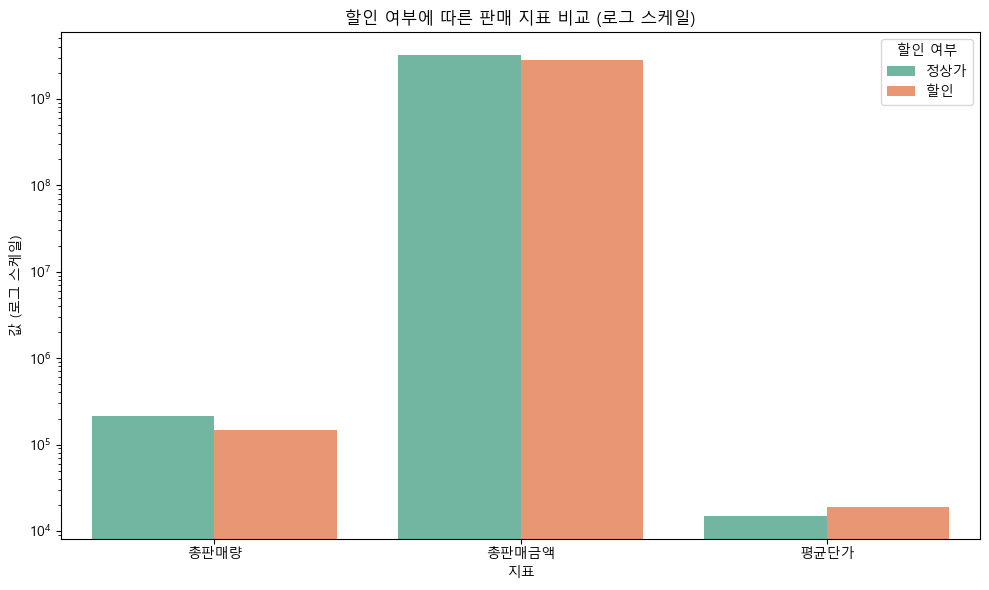

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 📊 데이터 불러오기
df = pd.read_csv("./data/20190509_mask_POS.csv", encoding="utf-8")

# 1. 필요한 열 필터링
df_price = df[['품목명', '가격', 'Sales SU', '금액']].dropna()
df_price = df_price[df_price['Sales SU'] > 0]

# 2. 품목별 정상단가 계산
avg_price = df_price.groupby('품목명')['가격'].mean().reset_index().rename(columns={'가격': '정상단가'})

# 3. 할인 여부 생성
df_price = df_price.merge(avg_price, on='품목명', how='left')
df_price['할인여부'] = df_price['가격'] < df_price['정상단가']
df_price['할인여부'] = df_price['할인여부'].map({True: '할인', False: '정상가'})

# 4. 할인 여부별 집계
grouped = df_price.groupby('할인여부').agg(
    총판매량=('Sales SU', 'sum'),
    총판매금액=('금액', 'sum')
).reset_index()
grouped['평균단가'] = grouped['총판매금액'] / grouped['총판매량']

# 5. long 형태로 변환 (시각화를 위해 melt)
grouped_melted = grouped.melt(id_vars='할인여부', var_name='지표', value_name='값')

# 6. 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_melted, x='지표', y='값', hue='할인여부', palette='Set2')

plt.yscale('log')  # 로그 스케일 적용
plt.title('할인 여부에 따른 판매 지표 비교 (로그 스케일)')
plt.xlabel('지표')
plt.ylabel('값 (로그 스케일)')
plt.legend(title='할인 여부')
plt.tight_layout()
plt.show()

## 계절 별 판매량

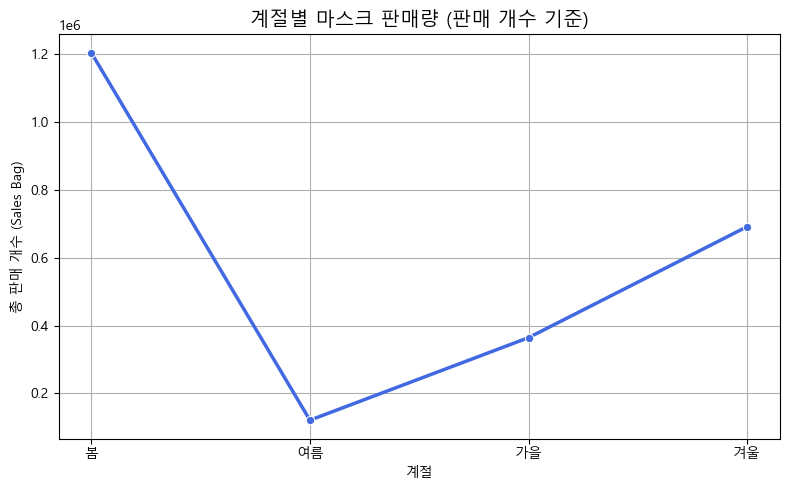

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 📊 1. 데이터 불러오기
df = pd.read_csv('./data/20190509_mask_POS.csv', encoding='utf-8')

# 2. 날짜 컬럼 처리
df['Calendar Day일 2'] = pd.to_datetime(df['Calendar Day일 2'], errors='coerce')
df = df.dropna(subset=['Calendar Day일 2'])

# 3. 계절 분류 함수 정의
def get_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

df['계절'] = df['Calendar Day일 2'].dt.month.apply(get_season)

# 4. 판매량 기준: 'Sales (Bag)' 사용
df = df.dropna(subset=['Sales (Bag)'])

# 5. 계절별 판매량 집계
season_sales = df.groupby('계절')['Sales (Bag)'].sum().reindex(['봄', '여름', '가을', '겨울']).reset_index()

# 6. 꺾은선 그래프 시각화
plt.figure(figsize=(8, 5))
sns.lineplot(data=season_sales, x='계절', y='Sales (Bag)', marker='o', linewidth=2.5, color='royalblue')

plt.title('계절별 마스크 판매량 (판매 개수 기준)', fontsize=14)
plt.xlabel('계절')
plt.ylabel('총 판매 개수 (Sales Bag)')
plt.grid(True)
plt.tight_layout()
plt.show()


## 유통사 별 판매량

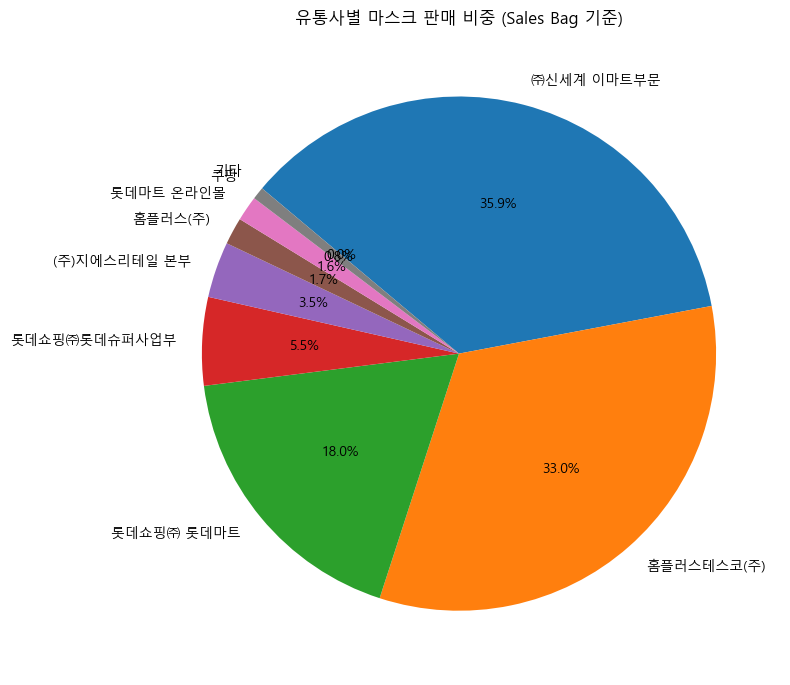

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import platform

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 불러오기
df = pd.read_csv("./data/20190509_mask_POS.csv", encoding="utf-8")

# 2. 유통사별 판매량 집계 (판매 개수 기준: Sales (Bag))
df = df.dropna(subset=['유통사', 'Sales (Bag)'])
dist_sales = df.groupby('유통사')['Sales (Bag)'].sum().reset_index()

# 3. 판매량 비중 기준으로 내림차순 정렬 & 상위 8개 + 기타 처리
dist_sales = dist_sales.sort_values(by='Sales (Bag)', ascending=False).reset_index(drop=True)

# 상위 8개만 표시, 나머지는 '기타'로 묶기
top_n = 8
if len(dist_sales) > top_n:
    top_df = dist_sales.iloc[:top_n].copy()
    other_sum = dist_sales.iloc[top_n:]['Sales (Bag)'].sum()
    top_df.loc[len(top_df)] = ['기타', other_sum]
else:
    top_df = dist_sales

# 4. 파이차트 시각화
plt.figure(figsize=(8, 8))
plt.pie(
    top_df['Sales (Bag)'],
    labels=top_df['유통사'],
    autopct='%1.1f%%',
    startangle=140,
    counterclock=False
)
plt.title('유통사별 마스크 판매 비중 (Sales Bag 기준)')
plt.tight_layout()
plt.show()
